In [1]:
import numpy as np
import pandas as pd
import yfinance as yf

In [2]:
stock_symbol = 'HCLTECH.NS'
stock_data = yf.download(stock_symbol,  period="max")

[*********************100%%**********************]  1 of 1 completed


In [3]:
stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2002-08-12,22.712500,23.987499,22.625000,23.762501,14.181609,11239400
2002-08-13,24.250000,24.250000,23.150000,23.325001,13.920505,3756368
2002-08-14,23.237499,23.237499,22.768749,23.006250,13.730274,3964016
2002-08-15,23.006250,23.006250,23.006250,23.006250,13.730274,0
2002-08-16,23.625000,23.750000,23.250000,23.606251,14.088361,4848904
...,...,...,...,...,...,...
2024-04-25,1479.949951,1515.050049,1479.949951,1504.150024,1504.150024,4558032
2024-04-26,1516.849976,1531.449951,1464.949951,1473.849976,1473.849976,4328477
2024-04-29,1415.000000,1436.000000,1381.000000,1387.400024,1387.400024,11493223


In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt


stock_data.reset_index(inplace=True)

# Extract the 'Date' and 'Close' columns
data = stock_data[['Date', 'Close']].copy()

In [5]:
# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Close']])

# Function to create dataset
def create_dataset(data, look_back=60):
    X, y = [], []
    for i in range(len(data)-look_back-1):
        X.append(data[i:(i+look_back)])
        y.append(data[i + look_back, 0])  # Close price is the label (index 0)
    return np.array(X), np.array(y)

# Create dataset with look-back window
look_back = 60  # Adjust this window size as needed
X, y = create_dataset(scaled_data, look_back)

# Reshape input data for LSTM (samples, time steps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [6]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [7]:
# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train model
model.fit(X, y, epochs=50, batch_size=32)

Epoch 1/50
167/167 [==============================] - 18s 12ms/step - loss: 0.0060
Epoch 2/50
167/167 [==============================] - 2s 12ms/step - loss: 0.0012
Epoch 3/50
167/167 [==============================] - 2s 15ms/step - loss: 0.0013
Epoch 4/50
167/167 [==============================] - 2s 13ms/step - loss: 9.3274e-04
Epoch 5/50
167/167 [==============================] - 2s 11ms/step - loss: 8.5091e-04
Epoch 6/50
167/167 [==============================] - 2s 11ms/step - loss: 7.7311e-04
Epoch 7/50
167/167 [==============================] - 2s 11ms/step - loss: 7.8246e-04
Epoch 8/50
167/167 [==============================] - 2s 12ms/step - loss: 7.9758e-04
Epoch 9/50
167/167 [==============================] - 2s 13ms/step - loss: 8.0464e-04
Epoch 10/50
167/167 [==============================] - 2s 14ms/step - loss: 7.3424e-04
Epoch 11/50
167/167 [==============================] - 2s 12ms/step - loss: 6.5127e-04
Epoch 12/50
167/167 [==============================] - 2s 12ms/

1/1 [==============================] - 0s 19ms/step


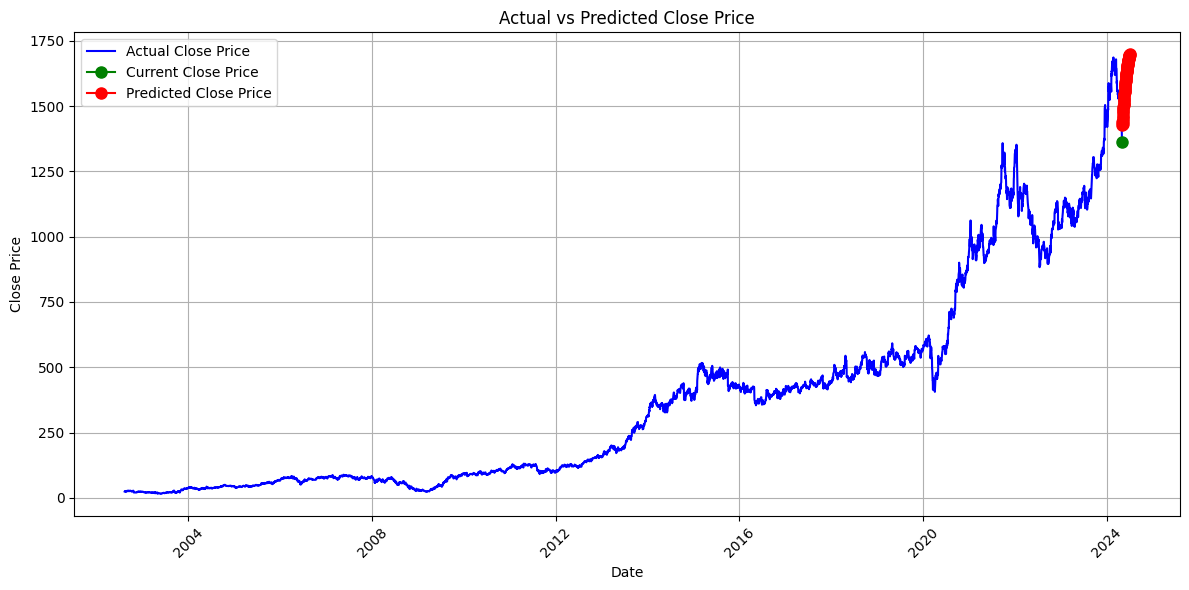

In [8]:
def predict_future_prices(model, data, look_back, num_days):
    last_sequence = data[-look_back:]  # Get the last sequence of known data
    predicted_prices = []
    for _ in range(num_days):
        prediction = model.predict(last_sequence.reshape(1, look_back, 1))  # Predict next day's price
        predicted_prices.append(prediction[0, 0])  # Append predicted price to list
        last_sequence = np.append(last_sequence[1:], prediction[0])  # Update last sequence with new prediction
    return scaler.inverse_transform(np.array(predicted_prices).reshape(-1, 1))[:, 0]

# Predict future prices for the next 20 days
num_days = 60  # Change this value to predict a different number of days into the future
predicted_prices = predict_future_prices(model, scaled_data, look_back, num_days)

# Plot actual and predicted closing prices
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], scaler.inverse_transform(scaled_data), label='Actual Close Price', color='blue')
plt.plot(data['Date'].iloc[-1:], scaler.inverse_transform(scaled_data)[-1:], marker='o', markersize=8, color='green', label='Current Close Price')
plt.plot(pd.date_range(start=data['Date'].iloc[-1], periods=num_days+1, freq='D')[1:], predicted_prices, marker='o', markersize=8, color='red', label='Predicted Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Close Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
predicted_prices

array([1439.8741, 1429.1338, 1431.9095, 1441.5155, 1453.0072, 1463.955 ,
       1473.6082, 1482.0256, 1489.5314, 1496.4574, 1503.0558, 1509.4884,
       1515.8434, 1522.1589, 1528.4415, 1534.6804, 1540.8582, 1546.9551,
       1552.9536, 1558.8401, 1564.6038, 1570.2379, 1575.7386, 1581.1039,
       1586.3334, 1591.4276, 1596.3882, 1601.2163, 1605.9141, 1610.4834,
       1614.926 , 1619.2439, 1623.4392, 1627.5138, 1631.4696, 1635.309 ,
       1639.0339, 1642.6467, 1646.1495, 1649.5447, 1652.8344, 1656.021 ,
       1659.107 , 1662.0948, 1664.9866, 1667.7848, 1670.4917, 1673.1097,
       1675.6411, 1678.0885, 1680.454 , 1682.7395, 1684.9478, 1687.0806,
       1689.1404, 1691.1293, 1693.0493, 1694.9028, 1696.6914, 1698.4175],
      dtype=float32)

In [10]:
model.save('HCLTECH.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [11]:
import joblib
joblib.dump(scaler, 'HCLTECH.pkl')

['HCLTECH.pkl']